# For High Society, Low Recycling: the notebook
By [Sawyer Click](https://sawyerclick.github.io)



### Table of Contents
- [__Monthly Tonnage Reports__](#monthly-tonnage-reports)

#### About this project
This project looks at the recycling habits of New York City community districts over the last few decades. More specifically, I'm drilling in to Monthly Tonnage Reports and Census data to note how a district's demographics, such as poverty rate, median household income, and race, play into these habits.

#### Data notes
Monthly Tonnage Reports track residences and institutions (not businesses) serviced by New York's Department of Sanitation

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import json
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
pd.set_option('display.max_colwidth', -1)

%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

# <a id='monthly-tonnage-reports'>Reading in Monthly Tonnage Reports</a>

The data is compiled from [Monthly Tonnage Reports](https://data.cityofnewyork.us/City-Government/DSNY-Monthly-Tonnage-Data/ebb7-mvp5) from the Department of Sanitation.

Rows are by __month__ and __community-district__, which let's us build a timeline of recycling in New York City's districts

In [2]:
## here's what our data looks like
reports = pd.read_csv('monthly_tonnage_reports.csv')
reports.head()

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID
0,1993 / 11,Manhattan,1,625.2,119.4,34.4,NaN,NaN,NaN,NaN,1
1,1995 / 09,Manhattan,1,633.1,117.2,45.8,NaN,NaN,NaN,NaN,1
2,1995 / 08,Manhattan,1,627.5,82.4,35.6,NaN,NaN,NaN,NaN,1
3,2012 / 03,Manhattan,1,1194.4,341.6,210.8,NaN,NaN,NaN,NaN,1
4,1992 / 03,Manhattan,1,726.0,NaN,NaN,NaN,NaN,NaN,NaN,1


## We need to run a bit of cleaning to help keep things organized

In [3]:
## let's fill NaNs with zeroes bc they mean 0 here
reports = reports.fillna(0)

## make datetime, separate the year
reports['datetime'] = pd.to_datetime(reports.MONTH)
reports['year'] = reports.datetime.astype(str).str.extract(r'^(.*)-.*-.*').astype(int)
reports['month'] = reports.datetime.astype(str).str.extract(r'^.*-(.*)-.*').astype(int)

## read back borough ids as strings
reports.BOROUGH_ID = reports.BOROUGH_ID.astype(str) 

# give the boro code by smashing together the borough id and community district number
def get_boro_code(x):
    return x.BOROUGH_ID + "{:02d}".format(x.COMMUNITYDISTRICT)
reports['borough_code'] = reports.apply(get_boro_code, axis=1)

## first we need to cut out 2020 months
## because the year isn't finished yet and we're most interested in years
reports = reports[(reports.year < 2020) & (reports.year > 2008)]

reports.head()

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID,datetime,year,month,borough_code
3,2012 / 03,Manhattan,1,1194.4,341.6,210.8,0.0,0.0,0.0,0.0,1,2012-03-01,2012,3,101
9,2012 / 01,Brooklyn,7,3156.7,436.6,343.4,0.0,0.0,0.0,20.1,3,2012-01-01,2012,1,307
13,2016 / 11,Brooklyn,7,3356.9,424.4,380.3,120.1,0.0,2.5,0.0,3,2016-11-01,2016,11,307
21,2013 / 11,Brooklyn,7,3179.2,398.7,318.3,57.5,0.0,0.0,0.0,3,2013-11-01,2013,11,307
23,2010 / 12,Brooklyn,7,2514.9,367.6,275.5,0.0,0.0,0.0,0.0,3,2010-12-01,2010,12,307


## Checking out refuse emissions from each borough

Remember! Some boroughs are more populous than others, cover a larger land mass, or have larger community districts. All of these mess with the raw numbers. This is mostly to give us an idea of what we're working with

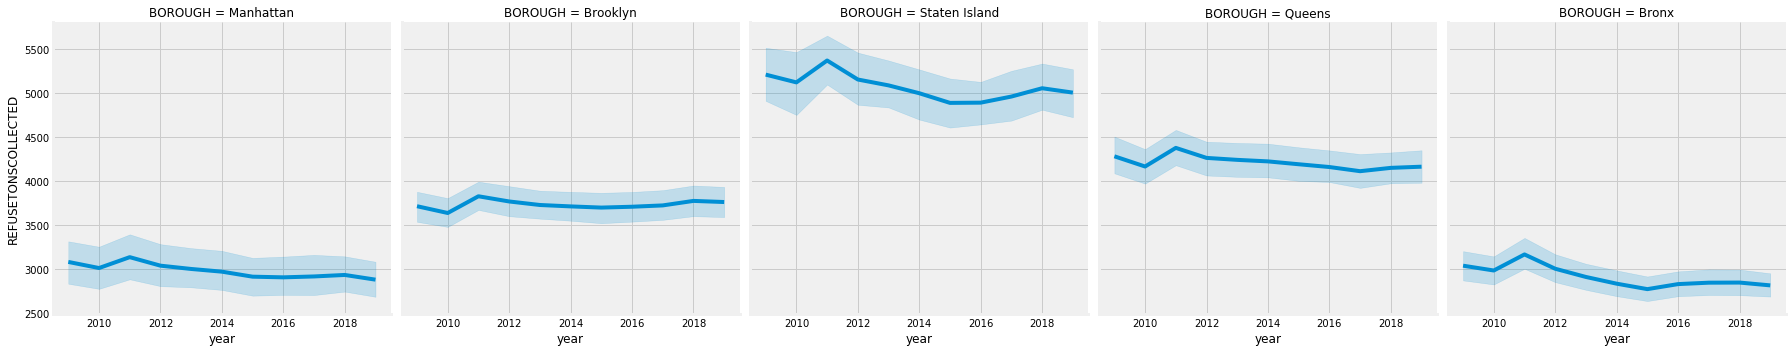

In [6]:
sns.relplot(data=reports,\
             x='year',\
             y='REFUSETONSCOLLECTED',\
             col='BOROUGH',\
             kind='line'\
            )

## Some cool math to get percentages!

In [7]:
reports.head()

,MONTH,BOROUGH,COMMUNITYDISTRICT,REFUSETONSCOLLECTED,PAPERTONSCOLLECTED,MGPTONSCOLLECTED,RESORGANICSTONS,SCHOOLORGANICTONS,LEAVESORGANICTONS,XMASTREETONS,BOROUGH_ID,datetime,year,month,borough_code
3,2012 / 03,Manhattan,1,1194.4,341.6,210.8,0.0,0.0,0.0,0.0,1,2012-03-01,2012,3,101
9,2012 / 01,Brooklyn,7,3156.7,436.6,343.4,0.0,0.0,0.0,20.1,3,2012-01-01,2012,1,307
13,2016 / 11,Brooklyn,7,3356.9,424.4,380.3,120.1,0.0,2.5,0.0,3,2016-11-01,2016,11,307
21,2013 / 11,Brooklyn,7,3179.2,398.7,318.3,57.5,0.0,0.0,0.0,3,2013-11-01,2013,11,307
23,2010 / 12,Brooklyn,7,2514.9,367.6,275.5,0.0,0.0,0.0,0.0,3,2010-12-01,2010,12,307


In [8]:
## these are the basic recycled materials. 
## Paper, plastics + metals, and organics
reports['total_recycled'] = reports.PAPERTONSCOLLECTED\
                            + reports.MGPTONSCOLLECTED\
                            + reports.RESORGANICSTONS

## we can calculate total waste by adding these up
## refuse refers to non-recycled materials
reports['total_waste'] = reports.total_recycled\
                        + reports.REFUSETONSCOLLECTED

## now we can calculate percents to help put everyone on the same level!!
reports['percent_recycled'] = reports['total_recycled'] / reports['total_waste'] * 100

## Sorting totals by year to get diversion

In [9]:
racingChart = reports.groupby('year').total_recycled.sum().reset_index(name='Recycled')

racingChart['Waste'] = reports.groupby('year').REFUSETONSCOLLECTED.sum().reset_index(name='Waste').Waste
racingChart['Total'] = reports.groupby('year').total_waste.sum().reset_index(name='Total').Total

racingChart.to_csv('year_raw_waste_and_recycled.csv', index=False)
racingChart['Diversion'] = racingChart['Recycled'] / racingChart['Waste'] * 100
racingChart

,year,Recycled,Waste,Total,Diversion
0,2009,542333.4,2591531.2,3133864.6,20.927141
1,2010,520237.5,2534393.8,3054631.3,20.527098
2,2011,521395.4,2663828.9,3185224.3,19.573157
3,2012,494795.4,2586978.9,3081774.3,19.126379
4,2013,504466.2,2553356.8,3057823.0,19.756980
5,2014,528324.9,2528444.5,3056769.4,20.895254
6,2015,552411.1,2498990.8,3051401.9,22.105367
7,2016,585830.0,2503022.1,3088852.1,23.404907
8,2017,600721.5,2504617.2,3105338.7,23.984563
9,2018,628501.1,2528028.2,3156529.3,24.861317


In [10]:
## what's been the change in the amount of refuse?
## this tells us if there's been a change in waste and consumer habits
(racingChart['Waste'][10] - racingChart['Waste'][0]) / racingChart['Waste'][0] * 100

-3.0131298438543785

In [11]:
reports.groupby('year').total_recycled.sum() / reports.groupby('year').total_waste.sum() * 100

year
2009    17.305579
2010    17.031106
2011    16.369189
2012    16.055537
2013    16.497561
2014    17.283767
2015    18.103518
2016    18.965945
2017    19.344798
2018    19.911144
2019    20.079690
dtype: float64

## Sorting so we can make a ridgeplot

In [12]:
print(reports.groupby('BOROUGH').percent_recycled.median().sort_values())

def get_order(x):
    if x.BOROUGH == 'Bronx':
        return 1
    elif x.BOROUGH == 'Brooklyn':
        return 2
    elif x.BOROUGH == 'Queens':
        return 3
    elif x.BOROUGH == 'Staten Island':
        return 4
    elif x.BOROUGH == 'Manhattan':
        return 5
    
reports['mean_order'] = reports.apply(get_order, axis=1)

reports = reports.sort_values('mean_order')

BOROUGH
Bronx            12.584109
Brooklyn         15.587882
Queens           18.636092
Staten Island    20.144908
Manhattan        23.607803
Name: percent_recycled, dtype: float64


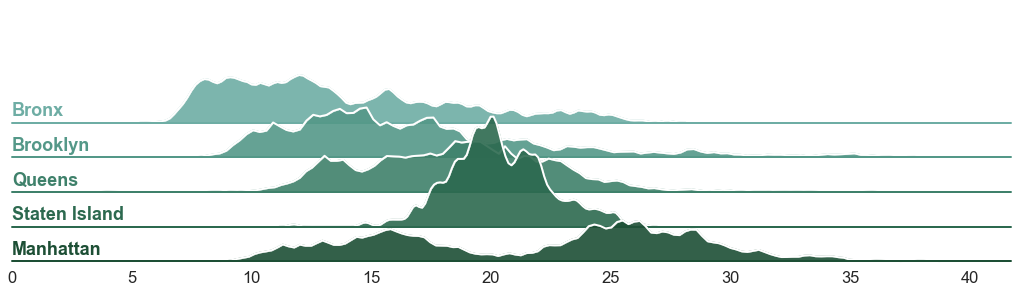

In [13]:
# https://seaborn.pydata.org/examples/kde_ridgeplot.html

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale = 1.5)

# Initialize the FacetGrid object
pal = sns.color_palette("ch:2,r=.2,l=.6")
g = sns.FacetGrid(reports, row="BOROUGH", hue="BOROUGH", aspect=15, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "percent_recycled", clip_on=False, shade=True, alpha=.9, lw=1.5, bw=.2)
g.map(sns.kdeplot, "percent_recycled", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)
    
g.map(label, "percent_recycled")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.7)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set_ylabels('')    
g.set_xlabels('')
g.set(yticks=[])
g.set(xticks=[0,5,10,15,20,25,30,35,40])
# g.set(xticklabe)
g.despine(bottom=True, left=True)

# plt.savefig('')

## percent difference calculator

In [14]:
## crude but a way to get unique borough codes matched
matchDF = reports[reports.year == 2019][['BOROUGH', 'borough_code', 'total_waste']].groupby(['BOROUGH','borough_code']).total_waste.sum().reset_index()

In [15]:
## 2019 community district recycling rates
bydist_2019 = (reports[reports['year'] == 2019].groupby('borough_code').total_recycled.sum()\
 / reports[reports['year'] == 2019].groupby('borough_code').total_waste.sum()\
 * 100).reset_index(name='pct_recyc_2019')

## 2009 community district recycling rates
bydist_2009 = (reports[reports['year'] == 2009].groupby('borough_code').total_recycled.sum()\
 / reports[reports['year'] == 2009].groupby('borough_code').total_waste.sum()\
 * 100).reset_index(name='pct_recyc_2009')

bydist = pd.merge(bydist_2019,bydist_2009, on='borough_code')
bydist.columns = ['borough_code','pct_recyc_2019','pct_recyc_2009']
bydist['pct_change'] = (bydist['pct_recyc_2019'] / bydist['pct_recyc_2009'] - 1) * 100

bydist['pct_point_change'] = bydist['pct_recyc_2019'] - bydist['pct_recyc_2009']

## adding comparitive raw data
## community district recycling, waste and refuse raw
bydist['raw_recyc2019'] = reports[reports['year'] == 2019].groupby('borough_code').total_recycled.sum().reset_index(name='total_recyc').total_recyc
bydist['raw_recyc2009'] = reports[reports['year'] == 2009].groupby('borough_code').total_recycled.sum().reset_index(name='total_recyc').total_recyc

bydist['raw_refuse2019'] = reports[reports['year'] == 2019].groupby('borough_code').REFUSETONSCOLLECTED.sum().reset_index(name='total_refuse').total_refuse
bydist['raw_refuse2009'] = reports[reports['year'] == 2009].groupby('borough_code').REFUSETONSCOLLECTED.sum().reset_index(name='total_refuse').total_refuse

## this is technically the ones above added together
bydist['raw_waste2019'] = reports[reports['year'] == 2019].groupby('borough_code').total_waste.sum().reset_index(name='total_waste').total_waste
bydist['raw_waste2009'] = reports[reports['year'] == 2009].groupby('borough_code').total_waste.sum().reset_index(name='total_waste').total_waste

## attach borough names
bydist = pd.merge(matchDF, bydist, on='borough_code')

## preview of our master set
bydist.head()

,BOROUGH,borough_code,total_waste,pct_recyc_2019,pct_recyc_2009,pct_change,pct_point_change,raw_recyc2019,raw_recyc2009,raw_refuse2019,raw_refuse2009,raw_waste2019,raw_waste2009
0,Bronx,201,26846.6,12.366184,7.870703,57.116635,4.495481,3319.9,1970.1,23526.7,23060.7,26846.6,25030.8
1,Bronx,202,21047.1,14.884711,8.893841,67.359754,5.990870,3132.8,1987.4,17914.3,20358.4,21047.1,22345.8
2,Bronx,203,26854.5,14.363328,7.740898,85.551197,6.622431,3857.2,1843.1,22997.3,21966.8,26854.5,23809.9
3,Bronx,204,55008.7,13.445328,7.735052,73.823361,5.710276,7396.1,4524.0,47612.6,53963.0,55008.7,58487.0
4,Bronx,205,47309.5,13.256323,10.276473,28.996815,2.979850,6271.5,5025.0,41038.0,43873.1,47309.5,48898.1


In [16]:
## is anyone producing more waste?
## this is what has killed zero waste in several cities

## new - old tells us who is recycling less. > 0 means there's more waste
moreWaste = bydist[bydist['raw_refuse2019'] - bydist['raw_refuse2009'] > 0]

print(f'There are {moreWaste.shape[0]} districts producing more waste out of the 59 total.')

moreWaste.BOROUGH.value_counts()

There are 20 districts producing more waste out of the 59 total.


Brooklyn     8
Queens       6
Manhattan    4
Bronx        2
Name: BOROUGH, dtype: int64

# Reading and cleaning demographic data

These are all from the census. I used social explorer

In [17]:
## there are a ton of columns so we're just going to use these
columns =[
    'borocd',
    'acres',
    'cd_full_title',
    'fp_100_rent_burden',
    'neighborhoods',
    'pct_bach_deg',
    'pct_foreign_born',
    'poverty_rate',
    'under18_rate'
]

demo_ish = pd.read_csv('demographic_data/cd_demographics.csv', usecols=columns)
demo_ish.borocd = demo_ish.borocd.astype(str)

demo_ish.head()

,acres,borocd,cd_full_title,fp_100_rent_burden,neighborhoods,pct_bach_deg,pct_foreign_born,poverty_rate,under18_rate
0,976.3,101,Manhattan Community District 1,0.353232,"Battery Park City, Civic Center, Ellis Island, Governors Island, Liberty Island, South Street Seaport, Tribeca, Wall Street, World Trade Center",82.3,23.9,8.8,12.8
1,865.9,102,Manhattan Community District 2,0.353232,"Greenwich Village, Hudson Square, Little Italy, NoHo, SoHo, South Village, West Village",82.3,23.9,8.8,12.8
2,1076.9,103,Manhattan Community District 3,0.463410,"Chinatown, East Village, Lower East Side, NoHo, Two Bridges",43.0,34.9,19.3,11.7
3,1131.6,104,Manhattan Community District 4,0.423210,"Chelsea, Clinton, Hudson Yards",74.4,29.4,11.3,8.2
4,1005.4,105,Manhattan Community District 5,0.000000,"Flatiron, Gramercy Park, Herald Square, Midtown, Midtown South, Murray Hill, Times Square, Union Square",74.4,29.4,11.3,8.2


In [18]:
## Fips here === community district
income = pd.read_csv('demographic_data/median_income.csv', skiprows=4, dtype={'Fips': str})

## stripping to most recent data | 2017
## and trimming it down to just the columns we need
income = income[(income.TimeFrame == 2017) & (income['Household Type'] == 'All Households')][['Data','Fips']].rename(columns={'Data':'income', 'Fips':'borocd'})

income.head()

,income,borocd
3120,144878.0,101
3121,144878.0,102
3122,39584.0,103
3123,101981.0,104
3124,101981.0,105


In [19]:
## Fips here === community district
population = pd.read_csv('demographic_data/total_population.csv', skiprows=4, dtype={'Fips': str})

## stripping to most recent data | 2017
## and trimming it down to just the columns we need
population = population[(population.TimeFrame == 2017) & (population['Fips'].str.contains(r'\w\w\w\w+') == False)][['Data','Fips', 'Location']].rename(columns={'Data':'population', 'Fips':'borocd'})

population.head()

,population,borocd,Location
780,60165.46615,101,Battery Park/Tribeca
781,88816.53385,102,Greenwich Village
782,160490.00000,103,Lower East Side
783,101603.53526,104,Chelsea/Clinton
784,50851.46474,105,Midtown Business District


In [20]:
income_and_pop = pd.merge(population, income, on='borocd')

In [21]:
## now we have a solid demographic dataset
demo = pd.merge(demo_ish, income_and_pop, on='borocd')
demo.head()

,acres,borocd,cd_full_title,fp_100_rent_burden,neighborhoods,pct_bach_deg,pct_foreign_born,poverty_rate,under18_rate,population,Location,income
0,976.3,101,Manhattan Community District 1,0.353232,"Battery Park City, Civic Center, Ellis Island, Governors Island, Liberty Island, South Street Seaport, Tribeca, Wall Street, World Trade Center",82.3,23.9,8.8,12.8,60165.46615,Battery Park/Tribeca,144878.0
1,865.9,102,Manhattan Community District 2,0.353232,"Greenwich Village, Hudson Square, Little Italy, NoHo, SoHo, South Village, West Village",82.3,23.9,8.8,12.8,88816.53385,Greenwich Village,144878.0
2,1076.9,103,Manhattan Community District 3,0.463410,"Chinatown, East Village, Lower East Side, NoHo, Two Bridges",43.0,34.9,19.3,11.7,160490.00000,Lower East Side,39584.0
3,1131.6,104,Manhattan Community District 4,0.423210,"Chelsea, Clinton, Hudson Yards",74.4,29.4,11.3,8.2,101603.53526,Chelsea/Clinton,101981.0
4,1005.4,105,Manhattan Community District 5,0.000000,"Flatiron, Gramercy Park, Herald Square, Midtown, Midtown South, Murray Hill, Times Square, Union Square",74.4,29.4,11.3,8.2,50851.46474,Midtown Business District,101981.0


# Merging recycling and demographic data

In [22]:
df = pd.merge(bydist, demo, left_on='borough_code',right_on='borocd')

df.head()

,BOROUGH,borough_code,total_waste,pct_recyc_2019,pct_recyc_2009,pct_change,pct_point_change,raw_recyc2019,raw_recyc2009,raw_refuse2019,...,cd_full_title,fp_100_rent_burden,neighborhoods,pct_bach_deg,pct_foreign_born,poverty_rate,under18_rate,population,Location,income
0,Bronx,201,26846.6,12.366184,7.870703,57.116635,4.495481,3319.9,1970.1,23526.7,...,Bronx Community District 1,0.580417,"Melrose, Mott Haven, Port Morris",10.3,29.5,31.0,28.4,99526.21296,Mott Haven,20966.0
1,Bronx,202,21047.1,14.884711,8.893841,67.359754,5.990870,3132.8,1987.4,17914.3,...,Bronx Community District 2,0.580417,"Hunts Point, Longwood",10.3,29.5,31.0,28.4,56830.78704,Hunts Point,20966.0
2,Bronx,203,26854.5,14.363328,7.740898,85.551197,6.622431,3857.2,1843.1,22997.3,...,Bronx Community District 3,0.530688,"Claremont, Crotona Park East, Melrose, Morrisania",13.3,31.4,30.3,28.9,92015.20058,Morrisania,25972.0
3,Bronx,204,55008.7,13.445328,7.735052,73.823361,5.710276,7396.1,4524.0,47612.6,...,Bronx Community District 4,0.617179,"Concourse, Concourse Village, East Concourse, Highbridge, Mount Eden, West Concourse",15.0,43.1,32.4,27.5,149710.00000,Concourse/Highbridge,30900.0
4,Bronx,205,47309.5,13.256323,10.276473,28.996815,2.979850,6271.5,5025.0,41038.0,...,Bronx Community District 5,0.650425,"Fordham, Morris Heights, Mount Hope, University Heights",13.1,43.4,35.6,28.7,148339.00000,University Heights,30166.0


In [23]:
## sorting from greatest change to least and given them places
df = df.sort_values('pct_point_change', ascending=False).reset_index(drop=True).reset_index().rename(columns={'index':'place'})

In [24]:
## send to a csv
df.to_csv('data.csv', index=False)

## take this to QGIS for a spatial join with community-districts.geojson
## export as data.geojson
## use mapshaper to make it data.json as topojson

In [29]:
lines = (reports.groupby(['borough_code', 'year']).total_recycled.sum()\
 / reports.groupby(['borough_code', 'year']).total_waste.sum()\
 * 100).reset_index(name='diversion')

lines.to_csv('diversions.csv', index=False)

# Analysis

In [30]:
## What's the city's median income?
median_income = df.income.median()

## Income histogram by community district

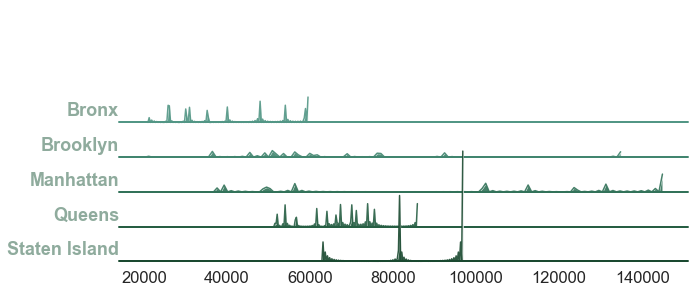

In [31]:
# https://seaborn.pydata.org/examples/kde_ridgeplot.html

sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale = 1.5)

# Initialize the FacetGrid object
pal = sns.color_palette("ch:2,r=.2,l=.5")
g = sns.FacetGrid(df, row="BOROUGH", hue="BOROUGH", aspect=10, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "income", clip_on=False, shade=True, alpha=.9, lw=1.5, bw=.2)
# g.map(sns.kdeplot, "income", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .1, label, fontweight="bold", color='#44745C',
            ha="right", va="center", transform=ax.transAxes, alpha=.6)
    
g.map(label, "income")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.7)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set_ylabels('')    
g.set_xlabels('')
g.set(yticks=[])
# g.set(xticks=[0,5,10,15,20,25,30,35,40])
# g.set(xticklabe)
g.despine(bottom=True, left=True)

# plt.savefig('')

### How rich are those recycling less?

FINDINGS:
- All five of the districts that are recycling a lower percentage of their waste have an income incredibly above the city's median of about $57k

In [32]:
df[df.pct_point_change < 0][['BOROUGH','borough_code','income']]

,BOROUGH,borough_code,income
54,Staten Island,502,81487.0
55,Brooklyn,318,76647.0
56,Staten Island,503,96796.0
57,Manhattan,101,144878.0
58,Manhattan,106,112383.0


Poorer districts made more significant gains


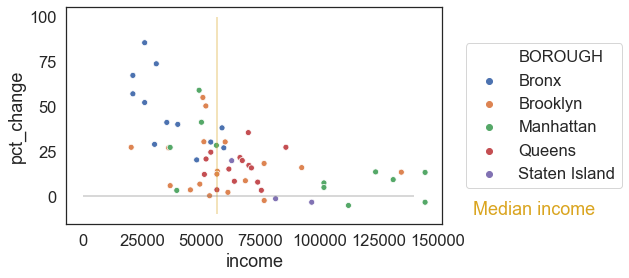

In [33]:
## this shows the percentage change, not percentage point change
## the idea is I want to see how significant of a shift the change was, not necessarily the raw change
g = sns.scatterplot(data=df, x='income', y='pct_change', hue='BOROUGH')
g.legend(loc='right', bbox_to_anchor=(1.5, 0.5), ncol=1, facecolor='w')
g.vlines(median_income, -10, 100, color='goldenrod', alpha=.4)
g.hlines(0,0,140000, color='gray', alpha=.4)
plt.text(165000,-10,'Median income', color='goldenrod')
print('Poorer districts made more significant gains')

Poorer districts made more significant gains


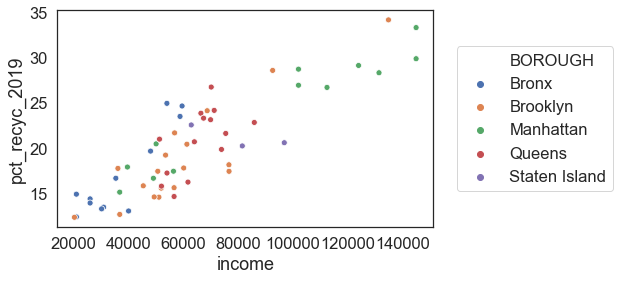

In [34]:
## this shows the percentage change, not percentage point change
## the idea is I want to see how significant of a shift the change was, not necessarily the raw change
g = sns.scatterplot(data=df, x='income', y='pct_recyc_2019', hue='BOROUGH')
g.legend(loc='right', bbox_to_anchor=(1.5, 0.5), ncol=1, facecolor='w')
# g.vlines(median_income, -10, 100, color='goldenrod', alpha=.4)
# g.hlines(0,0,140000, color='gray', alpha=.4)
# plt.text(165000,-10,'Median income', color='goldenrod')
print('Poorer districts made more significant gains')

In [35]:
## The average person in the city is resposible for 
# 364,725 pounds of waste sent to a landfill, incinerator or the ocean
(df.raw_waste2019.sum() * 1000000) / df.population.sum()

364725.16237252933

In [36]:
df[((df.raw_refuse2009 - df.raw_refuse2019) < 0) & (df.income > median_income)][['BOROUGH','borough_code','raw_refuse2019', 'raw_refuse2009', 'income', 'pct_point_change']]

,BOROUGH,borough_code,raw_refuse2019,raw_refuse2009,income,pct_point_change
18,Brooklyn,302,29941.8,25913.4,92562.0,3.955169
20,Queens,402,35340.1,32472.7,67359.0,3.883460
33,Brooklyn,301,64018.7,53459.1,76608.0,2.814174
39,Queens,412,81078.8,79745.1,61670.0,2.146558
43,Queens,408,43169.5,42020.8,64005.0,1.612985
44,Queens,410,44977.0,44462.9,73891.0,1.467025
45,Manhattan,104,28331.4,25160.8,101981.0,1.375338
52,Brooklyn,315,53355.0,52977.6,61274.0,0.456551
55,Brooklyn,318,65818.4,64147.4,76647.0,-0.402186
57,Manhattan,101,16545.7,13451.8,144878.0,-1.109078


In [48]:
df[df.income < median_income][['BOROUGH','borough_code','pct_point_change', 'place']].shape[0]

29

In [61]:
df.sort_values('pct_point_change')[['BOROUGH','borough_code','pct_point_change', 'raw_waste2019','raw_waste2009', 'raw_recyc2019','raw_recyc2009']].head()

,BOROUGH,borough_code,pct_point_change,raw_waste2019,raw_waste2009,raw_recyc2019,raw_recyc2009
58,Manhattan,106,-1.407075,46916.1,50593.9,12533.4,14227.8
57,Manhattan,101,-1.109078,24823.0,20522.8,8277.3,7071.0
56,Staten Island,503,-0.682895,86217.5,88949.5,17750.6,18920.5
55,Brooklyn,318,-0.402186,79701.1,78057.8,13882.7,13910.4
54,Staten Island,502,-0.259969,63637.0,65646.0,12874.4,13451.5


In [55]:
df.sort_values('income', ascending=False)[['BOROUGH','borough_code','income','pct_point_change']].head(10)

,BOROUGH,borough_code,income,pct_point_change
25,Manhattan,102,144878.0,3.529911
57,Manhattan,101,144878.0,-1.109078
17,Brooklyn,306,134804.0,4.069437
37,Manhattan,108,131348.0,2.426845
26,Manhattan,107,123894.0,3.501982
58,Manhattan,106,112383.0,-1.407075
45,Manhattan,104,101981.0,1.375338
41,Manhattan,105,101981.0,1.888399
56,Staten Island,503,96796.0,-0.682895
18,Brooklyn,302,92562.0,3.955169


In [52]:
df[df.pct_point_change < 0][['place','BOROUGH','borough_code','income','neighborhoods']]

,place,BOROUGH,borough_code,income,neighborhoods
54,54,Staten Island,502,81487.0,"Arrochar, Bloomfield, Bulls Head, Chelsea, Concord, Dongan Hills, Egbertville, Emerson Hill, Grant City, Grasmere, Heartland Village, Lighthouse Hill, Manor Heights, Midland Beach, New Dorp, New Dorp Beach, New Springville, Old Town, South Beach, Todt Hill, Travis, Willowbrook"
55,55,Brooklyn,318,76647.0,"Bergen Beach, Canarsie, Flatlands, Georgetown, Marine Park, Mill Basin, Mill Island, Paerdegat Basin"
56,56,Staten Island,503,96796.0,"Annadale, Arden Heights, Bay Terrace, Butler Manor, Charleston, Eltingville, Fresh Kills, Great Kills, Greenridge, Huguenot, Oakwood, Oakwood Beach, Oakwood Heights, Pleasant Plains, Prince's Bay, Richmond Town, Richmond Valley, Rossville, Sandy Ground, Tottenville, Woodrow"
57,57,Manhattan,101,144878.0,"Battery Park City, Civic Center, Ellis Island, Governors Island, Liberty Island, South Street Seaport, Tribeca, Wall Street, World Trade Center"
58,58,Manhattan,106,112383.0,"Beekman Place, Gramercy Park, Murray Hill, Peter Cooper Village, Stuyvesant Town, Sutton Place, Tudor City, Turtle Bay"


In [38]:
df.total_waste.sum()

3144939.0000000005